In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, LoggingHandler, InputExample, losses, evaluation
from sentence_transformers.losses import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
LOSS_NAME = "ContrastiveLoss"
POOLING_MODE = "max"

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

pooler = models.Pooling(encoder.get_word_embedding_dimension(), pooling_mode = POOLING_MODE)


model = SentenceTransformer(modules=[encoder, pooler])

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

# Construct Contrastive Dataset

In [4]:
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

# sequences = [["00" + str(i) for i in range(10, 34)],
#              ["10" + str(i) for i in range(10, 34)],
#              ["20" + str(i) for i in range(10, 34)],
#              ["30" + str(i) for i in range(10, 34)],
#              ["40" + str(i) for i in range(10, 34)]]

examples = []
r = 1
done = False
while not done:
    #print("round", r)
    for a_p_list_id in range(len(sequences)):
        n_list_ids = list(range(len(sequences))).copy()
        n_list_ids.remove(a_p_list_id)
        anchor_positive_list = sequences[a_p_list_id]
        anchor_positives = random.sample(anchor_positive_list, 5)
        anchor = anchor_positives[0]
        positives = anchor_positives[1:]
        anchor_positive_list.remove(anchor)
        for positive in positives:
            examples.append(InputExample(texts=[anchor, positive], label=1))
            #print(f"[{anchor}, {positive}, 1]")
            anchor_positive_list.remove(positive)
        

        for n_list_id in n_list_ids:
            negative_list = sequences[n_list_id]
            negative = random.choice(negative_list)
            negative_list.remove(negative)
            examples.append(InputExample(texts=[anchor, negative], label=0))
            #print(f"[{anchor}, {negative}, 0]")
        if len(sequences[0]) < 5 or len(sequences[1]) < 5 or len(sequences[2]) < 5 or len(sequences[3]) < 5 or len(sequences[4]) < 5:
            done = True
            break
    r += 1

print("len(examples): ", len(examples))
print("len(sequences[0]): ", len(sequences[0]))
print("len(sequences[1]): ", len(sequences[1]))
print("len(sequences[2]): ", len(sequences[2]))
print("len(sequences[3]): ", len(sequences[3]))
print("len(sequences[4]): ", len(sequences[4]))

len(examples):  8864
len(sequences[0]):  4
len(sequences[1]):  4
len(sequences[2]):  4
len(sequences[3]):  8
len(sequences[4]):  8


In [5]:
train_examples = examples[:int(len(examples)*0.8)]
dev_examples = examples[int(len(examples)*0.8):int(len(examples)*0.9)]
test_examples = examples[int(len(examples)*0.9):]

In [6]:
batch_size = 200
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_examples, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=batch_size)

In [8]:
train_loss = losses.ContrastiveLoss(model=model, distance_metric=SiameseDistanceMetric.EUCLIDEAN, margin=5)

In [9]:
evaluator = evaluation.BinaryClassificationEvaluator(sentences1=[dev_example.texts[0] for dev_example in dev_examples],
                                                     sentences2=[dev_example.texts[1] for dev_example in dev_examples],
                                                     labels=[dev_example.label for dev_example in dev_examples],
                                                     batch_size=batch_size,
                                                     show_progress_bar=False,
                                                     write_csv=True,
                                                     name="validation")

In [10]:
import os

# Create output directory if needed
output_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}"
checkpoint_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/checkpoints"
evaluator_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/eval"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(evaluator_dir):
    os.makedirs(evaluator_dir)

# read loss values from csv:
train_results_file = os.path.join(output_dir, 'eval', 'training_results.csv')
val_results_file = os.path.join(output_dir, 'eval', 'validation_results.csv')

In [9]:
# Check if the file exists before attempting to delete
if os.path.exists(train_results_file):
    try:
        # Attempt to remove the file
        os.remove(train_results_file)
        print(f"File {train_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {train_results_file} does not exist.")

# Check if the file exists before attempting to delete
if os.path.exists(val_results_file):
    try:
        # Attempt to remove the file
        os.remove(val_results_file)
        print(f"File {val_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {val_results_file} does not exist.")

File ./ContrastiveLoss_output_max/eval/training_results.csv does not exist.
File ./ContrastiveLoss_output_max/eval/validation_results.csv does not exist.


In [10]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=30,
          optimizer_params= {'lr': 1e-3}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=eval_iter, # run an evalution in every 10% 
          output_path=output_dir,
          save_best_model=True,
          checkpoint_path=checkpoint_dir,
          checkpoint_save_steps=500,
          checkpoint_save_total_limit=2,
          show_progress_bar=True,
          loss_name=LOSS_NAME)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 38.79   Train Accuracy = 60.44
Valid Loss = 20.99   Valid Accuracy = 53.05


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 5.87   Train Accuracy = 56.04
Valid Loss = 4.20   Valid Accuracy = 54.51


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 3.16   Train Accuracy = 56.04
Valid Loss = 5.39   Valid Accuracy = 54.63


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 3.12   Train Accuracy = 62.64
Valid Loss = 5.40   Valid Accuracy = 55.08


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 3.10   Train Accuracy = 60.44
Valid Loss = 5.27   Valid Accuracy = 56.09


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 2.94   Train Accuracy = 70.33
Valid Loss = 3.34   Valid Accuracy = 61.85


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 2.40   Train Accuracy = 73.63
Valid Loss = 2.70   Valid Accuracy = 68.96


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 1.70   Train Accuracy = 86.81
Valid Loss = 2.06   Valid Accuracy = 77.31


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 1.67   Train Accuracy = 84.62
Valid Loss = 1.74   Valid Accuracy = 81.15


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 1.42   Train Accuracy = 89.01
Valid Loss = 1.54   Valid Accuracy = 84.65


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 10 ---
Train Loss = 0.81   Train Accuracy = 96.70
Valid Loss = 1.48   Valid Accuracy = 84.99


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 11 ---
Train Loss = 0.77   Train Accuracy = 95.60
Valid Loss = 1.41   Valid Accuracy = 86.79


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 12 ---
Train Loss = 0.70   Train Accuracy = 96.70
Valid Loss = 1.35   Valid Accuracy = 86.46


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 13 ---
Train Loss = 0.57   Train Accuracy = 98.90
Valid Loss = 1.27   Valid Accuracy = 87.58


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 14 ---
Train Loss = 0.34   Train Accuracy = 100.00
Valid Loss = 1.48   Valid Accuracy = 87.36


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 15 ---
Train Loss = 0.24   Train Accuracy = 100.00
Valid Loss = 1.43   Valid Accuracy = 87.47


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 16 ---
Train Loss = 0.36   Train Accuracy = 98.90
Valid Loss = 1.23   Valid Accuracy = 88.83


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 17 ---
Train Loss = 0.29   Train Accuracy = 100.00
Valid Loss = 1.12   Valid Accuracy = 87.81


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 18 ---
Train Loss = 0.36   Train Accuracy = 100.00
Valid Loss = 1.14   Valid Accuracy = 88.94


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 19 ---
Train Loss = 0.25   Train Accuracy = 100.00
Valid Loss = 1.10   Valid Accuracy = 88.83


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 20 ---
Train Loss = 0.23   Train Accuracy = 100.00
Valid Loss = 1.21   Valid Accuracy = 89.50


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 21 ---
Train Loss = 0.25   Train Accuracy = 100.00
Valid Loss = 1.04   Valid Accuracy = 89.16


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 22 ---
Train Loss = 0.14   Train Accuracy = 100.00
Valid Loss = 1.05   Valid Accuracy = 90.07


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 23 ---
Train Loss = 0.16   Train Accuracy = 100.00
Valid Loss = 1.02   Valid Accuracy = 90.41


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 24 ---
Train Loss = 0.21   Train Accuracy = 100.00
Valid Loss = 0.98   Valid Accuracy = 90.63


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 25 ---
Train Loss = 0.11   Train Accuracy = 100.00
Valid Loss = 1.21   Valid Accuracy = 89.73


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 26 ---
Train Loss = 0.23   Train Accuracy = 100.00
Valid Loss = 1.15   Valid Accuracy = 90.07


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 27 ---
Train Loss = 0.16   Train Accuracy = 100.00
Valid Loss = 1.07   Valid Accuracy = 90.74


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 28 ---
Train Loss = 0.07   Train Accuracy = 100.00
Valid Loss = 1.19   Valid Accuracy = 90.29


Iteration:   0%|          | 0/36 [00:00<?, ?it/s]

--- Epoch 29 ---
Train Loss = 0.18   Train Accuracy = 100.00
Valid Loss = 2.13   Valid Accuracy = 87.02


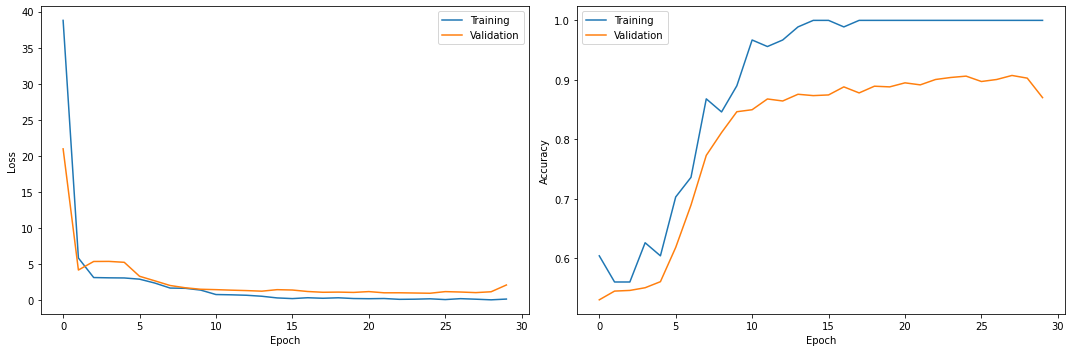

In [11]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# read loss values from csv:
train_results = pd.read_csv(train_results_file)
val_results = pd.read_csv(val_results_file)

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_results["epoch"], train_results["loss"], label="Training")
axs[0].plot(val_results["epoch"], val_results["loss"], label="Validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_results["epoch"], train_results["accuracy"], label="Training")
axs[1].plot(val_results["epoch"], val_results["accuracy"], label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(output_dir, "eval", f'plot_{LOSS_NAME}_{POOLING_MODE}.pdf'))
plt.show()

In [23]:

test_evaluator = evaluation.BinaryClassificationEvaluator(sentences1=[test_example.texts[0] for test_example in test_examples],
                                                     sentences2=[test_example.texts[1] for test_example in test_examples],
                                                     labels=[test_example.label for test_example in test_examples],
                                                     batch_size=100,
                                                     show_progress_bar=False,
                                                     name="test")

# load best model
best_model = SentenceTransformer(output_dir)
best_model.to("cuda")

# print test duration

import time
start_time = time.time()
test_acc = best_model.evaluate(test_evaluator)
duration = time.time() - start_time
print(f"Test duration: {duration} seconds")

# write test accuracy to file
with open(os.path.join(output_dir, "eval", "test_results.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")

print(duration * 1000 / len(test_examples), "ms per example")

Valid Loss = 1.09   Valid Accuracy = 90.53
Test duration: 0.1929152011871338 seconds
0.02174917713496435 ms per example
